In [2]:
import gymnasium as gym
import pygame
import matplotlib.pyplot as plt
import numpy as np


from scipy.signal import savgol_filter

q_table = None

def train(episodes=4000,
          learning_rate=0.1,
          discount_factor=0.9,
          cost_of_living=0.01,
          T = 100,
          render=False,
          isSlippery = True,
          label ='base'):
    
    pygame.init()
    
    global q_table
    env = gym.make("FrozenLake8x8-v1", is_slippery = isSlippery, render_mode= 'human' if render else None)

    q_table = np.zeros([env.observation_space.n, env.action_space.n])
    
    
    epsilon = 1
    epsilon_decay = 1/(episodes * 0.9)
    random_number_generator = np.random.default_rng()
    rewards_per_episode = np.zeros(episodes)
    time_rewards_per_episode = np.zeros(episodes)
    steps_per_episode = []
    
    for i in range(episodes):
        state = env.reset()[0]
        steps = 0

        for step in range(T):
            if random_number_generator.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state, :])
                
            new_state, reward, terminated, truncated,_ = env.step(action)

            if terminated & (reward == 0):
                reward = reward - 1

            if reward == 1:
                rewards_per_episode[i] = 1
                time_rewards_per_episode[i] = 1 - steps *  cost_of_living
                steps_per_episode.append(steps)
                reward = reward - cost_of_living * steps


            q_table[state, action] += reward + learning_rate * (reward + discount_factor * np.max(q_table[new_state, :]) - q_table[state, action])
            
            state = new_state
            
            steps += 1

            if terminated or truncated:
                break

        
        epsilon = max(epsilon - epsilon_decay, 0)
        
        if epsilon == 0:
            learning_rate = learning_rate * 0.1

        
            
        # print(f"Episode {i} | rewards {time_rewards_per_episode[i]} | Epsilon {epsilon}")
        
    env.close()
    pygame.quit()

    sum_rewards = np.zeros(episodes)
    for t in range(episodes) :
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])
    plt.plot(sum_rewards)


    moving_average_window = 3000
    moving_averages = savgol_filter(rewards_per_episode * 100 , moving_average_window, 5)
    
    plt.plot(moving_averages, label=f'{label}')
    
    plt.ylim(0, 100)
    
    plt.title(label)

    plt.legend()
    
    print("__________________________________")
    
    print(f"{label}")
    
    mean_reward_rate = np.mean(rewards_per_episode[int(len(rewards_per_episode) * 0.9):])
    print(f"Mean reward rate: {mean_reward_rate}")

    mean_steps = np.mean(steps_per_episode[int(len(steps_per_episode) * 0.9):])
    print(f"Mean steps per success episode: {mean_steps}")
    

    
    
def run(episodes = 1):
    global q_table
    pygame.init()
    env = gym.make("FrozenLake8x8-v1", is_slippery=True, render_mode= 'human')

    for i in range(episodes):
        state = env.reset()[0]
        terminated = False
        truncated = False

        while(not terminated and not truncated):
            action = np.argmax(q_table[state, :])
            
            new_state, reward, terminated, truncated,_ = env.step(action)

            state = new_state

    env.close()
    
    pygame.quit()


__________________________________
base
Mean reward rate: 0.626
Mean steps per success episode: 65.10691823899371


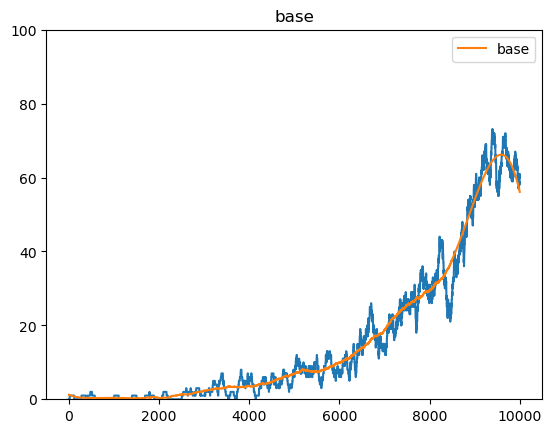

In [3]:
train(episodes=10000,learning_rate=0.05, cost_of_living=0.005, render=False)

In [4]:
run(episodes=4)

In [11]:
q_table

array([[ 4.21031612e-02,  4.31381927e-02,  4.20600723e-02,
         4.93747190e-02],
       [ 5.52772871e-02,  5.64265499e-02,  6.18750301e-02,
         5.68387479e-02],
       [ 8.09715805e-02,  8.27291121e-02,  9.55592504e-02,
         8.12275421e-02],
       [ 1.15945611e-01,  1.18388157e-01,  1.42049023e-01,
         1.18648548e-01],
       [ 1.69491331e-01,  1.76187710e-01,  1.96990154e-01,
         1.76187576e-01],
       [ 2.52925717e-01,  2.53418539e-01,  2.95228816e-01,
         2.52195129e-01],
       [ 3.32104946e-01,  3.31528072e-01,  3.91716645e-01,
         3.30625976e-01],
       [ 3.68345629e-01,  3.68674348e-01,  4.66864044e-01,
         3.70427969e-01],
       [ 4.03452378e-02,  4.05168374e-02,  3.69309292e-02,
         4.45906261e-02],
       [-5.38858552e-03, -1.73697314e-02,  1.96035972e-02,
         5.79001656e-02],
       [-1.29052908e-01, -2.29413631e-01, -2.84811278e-01,
         8.70266130e-02],
       [-8.44500000e+00, -5.93206985e+00, -8.24547148e+00,
      

ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

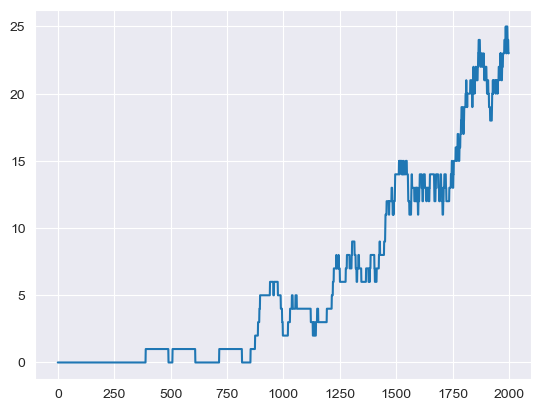

In [3]:
train(episodes=2000, learning_rate=0.0001, label="LR 0.0001")
train(episodes=2000, learning_rate=0.01, label="LR 0.01")
train(episodes=2000, learning_rate=0.1, label="LR 0.1")
train(episodes=2000, learning_rate=0.5, label="LR 0.5")

plt.title("Learning Curves: Varying Learning rates")
plt.xlabel("Episodes")
plt.ylabel("Smoothed Rewards")
plt.legend()
plt.show()


__________________________________
DF 0.99
Mean reward rate: 0.6235
Mean steps per success episode: 63.74829931972789
__________________________________
DF 0.2
Mean reward rate: 0.3815
Mean steps per success episode: 64.23985239852398


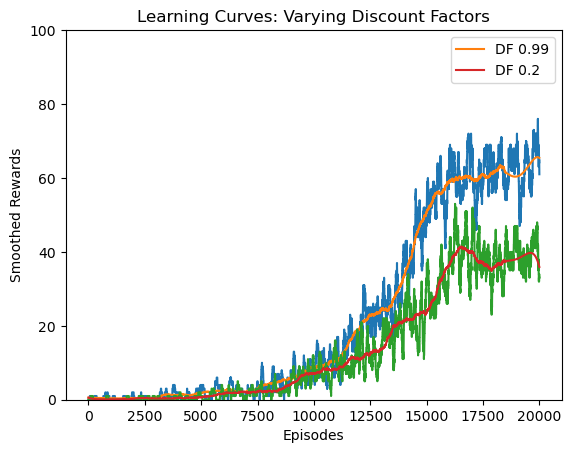

In [63]:

# Different Discount Factors
train(episodes=20000, discount_factor=0.99, label="DF 0.99")
train(episodes=20000, discount_factor=0.2, label="DF 0.2")

plt.title("Learning Curves: Varying Discount Factors")
plt.xlabel("Episodes")
plt.ylabel("Smoothed Rewards")
plt.legend()
plt.show()


__________________________________
10000 episodes
Mean reward rate: 0.435
Mean steps per success episode: 67.05960264900662
__________________________________
20000 episodes
Mean reward rate: 0.5725
Mean steps per success episode: 62.029126213592235
__________________________________
40000 episodes
Mean reward rate: 0.6065
Mean steps per success episode: 64.91618828932262
__________________________________
100000 episodes
Mean reward rate: 0.618
Mean steps per success episode: 63.180788400543726


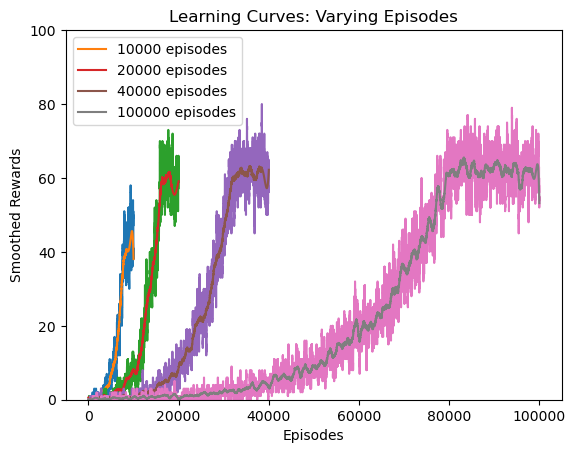

In [64]:
train(episodes=10000, learning_rate=0.01, label="10000 episodes")

train(episodes=20000, learning_rate=0.01, label="20000 episodes")

train(episodes=40000, learning_rate=0.01, label="40000 episodes")

train(episodes=100000, learning_rate=0.01, label="100000 episodes")

plt.title("Learning Curves: Varying Episodes")
plt.xlabel("Episodes")
plt.ylabel("Smoothed Rewards")
plt.legend()
plt.show()
